In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

VISUALISATION DES VARIABLES CLÉES

In [4]:
df = pd.read_csv("Australian_Student_PerformanceData (ASPD24).csv")

In [5]:
df = df.head(2000)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 51 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Student ID                                   2000 non-null   int64  
 1   University ID                                2000 non-null   int64  
 2   University Name                              2000 non-null   object 
 3   Age                                          2000 non-null   int64  
 4   Gender                                       2000 non-null   object 
 5   Major                                        2000 non-null   object 
 6   Year of Study                                2000 non-null   int64  
 7   GPA                                          2000 non-null   float64
 8   High School GPA                              2000 non-null   float64
 9   Entrance Exam Score                          2000 non-null   int64  
 10  

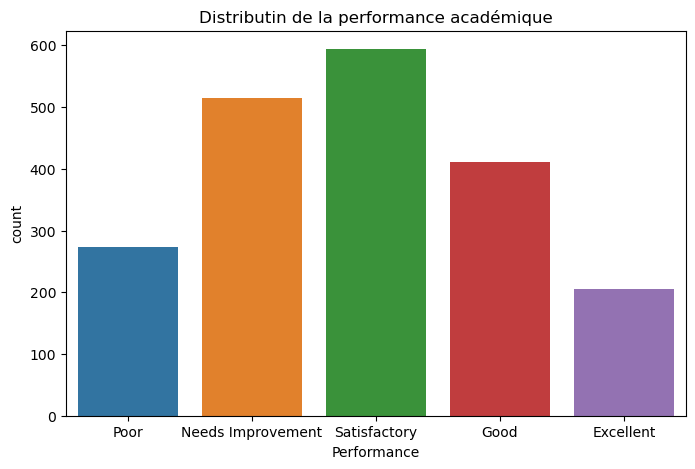

In [7]:
#Distribution de la variable cible

plt.figure(figsize=(8,5))
sns.countplot(data = df , x ="Performance" ,order=['Poor', 'Needs Improvement', 'Satisfactory', 'Good', 'Excellent'])
plt.title("Distributin de la performance académique")
plt.show()

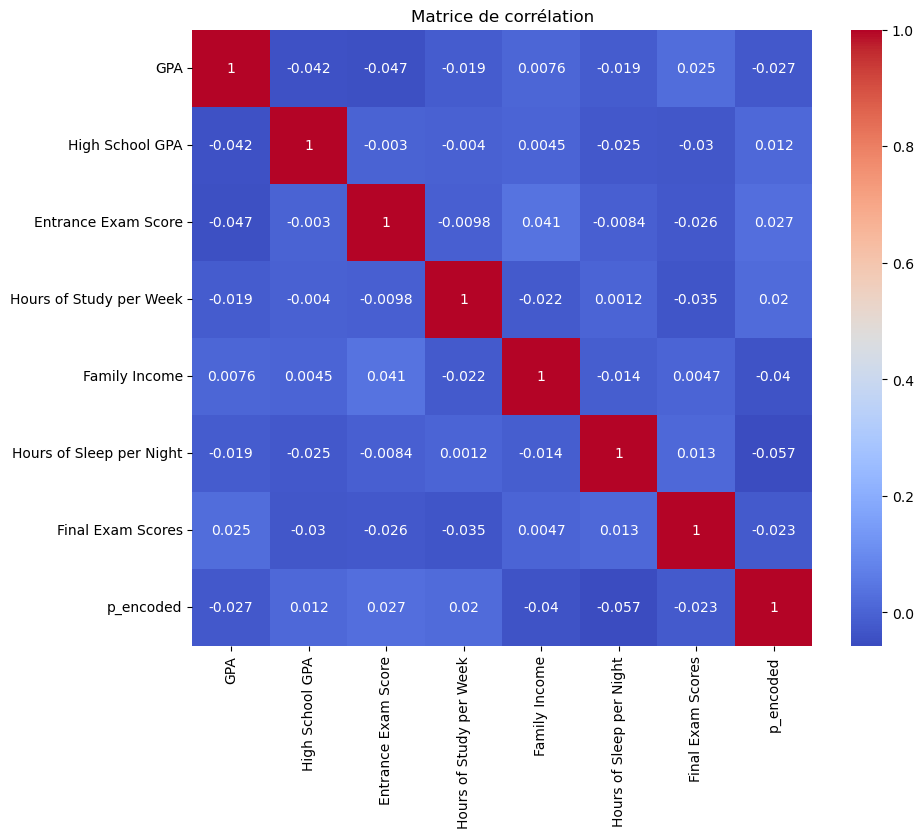

In [8]:
#Corrélation entre les principaux variable et la "performance"

pvars = ['GPA', 'High School GPA', 'Entrance Exam Score', 'Hours of Study per Week', 'Family Income', 'Hours of Sleep per Night', 'Final Exam Scores']

le = LabelEncoder()
df['p_encoded'] = le.fit_transform(df['Performance'])

corr_matrix = df[pvars + ['p_encoded']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()

NOUS REMARQUONS UNE CERTAINES INCOHERENCES DANS LA CORRELATION

In [9]:
df[['GPA' , 'Performance']].sample(5) 
#Nous remarquons des donn"es conttre intuitif


,GPA,Performance
506,1.58,Poor
880,2.73,Good
1819,3.20,Satisfactory
1586,3.51,Good
1919,3.96,Needs Improvement


In [10]:
df[['Final Exam Scores' , 'Performance']].sample(5)

,Final Exam Scores,Performance
323,58,Good
1667,91,Poor
1399,90,Good
1483,89,Excellent
1233,55,Poor


In [11]:
df.groupby('Performance')['GPA'].describe()

,count,mean,std,min,25%,50%,75%,max
Performance,,,,,,,,
Excellent,206.0,2.456602,0.857585,1.01,1.7950,2.330,3.1900,3.97
Good,411.0,2.538078,0.880559,1.01,1.7600,2.560,3.2900,4.00
Needs Improvement,515.0,2.495379,0.855562,1.01,1.7500,2.490,3.2300,4.00
Poor,274.0,2.478248,0.868568,1.01,1.7200,2.415,3.2275,3.99
Satisfactory,594.0,2.439158,0.842060,1.00,1.6725,2.440,3.1600,4.00


In [12]:
# Vérification des cas extrêmes
print("Étudiants avec GPA=4.0 et performance 'Poor':")
print(df[df['GPA']==4.0][['GPA', 'Performance']].head())

print("\nÉtudiants avec GPA=1.0 et performance 'Excellent':")
print(df[df['GPA']==1.0][['GPA', 'Performance']].head())

# Test statistique
from scipy.stats import f_oneway
groups = [group['GPA'].values for name, group in df.groupby('Performance')]
f_stat, p_value = f_oneway(*groups)

print(f"\nTest ANOVA: p-value={p_value:.5f}")

Étudiants avec GPA=4.0 et performance 'Poor':
      GPA        Performance
95    4.0  Needs Improvement
648   4.0               Good
1169  4.0       Satisfactory

Étudiants avec GPA=1.0 et performance 'Excellent':
      GPA   Performance
287   1.0  Satisfactory
1727  1.0  Satisfactory

Test ANOVA: p-value=0.47218


In [13]:
# Normalisation des scores (0-100 scale)
df['Normalized_GPA'] = (df['GPA']/4)*100
df['Composite_Score'] = (df['Normalized_GPA']*0.4 + df['Final Exam Scores']*0.6)

# Segmentation en catégories de performance
performance_bins = [0, 50, 65, 80, 90, 101]
performance_labels = ['Poor', 'Needs Improvement', 'Satisfactory', 'Good', 'Excellent']

df['Performance_Recalculated'] = pd.cut(df['Composite_Score'],bins=performance_bins, labels=performance_labels)

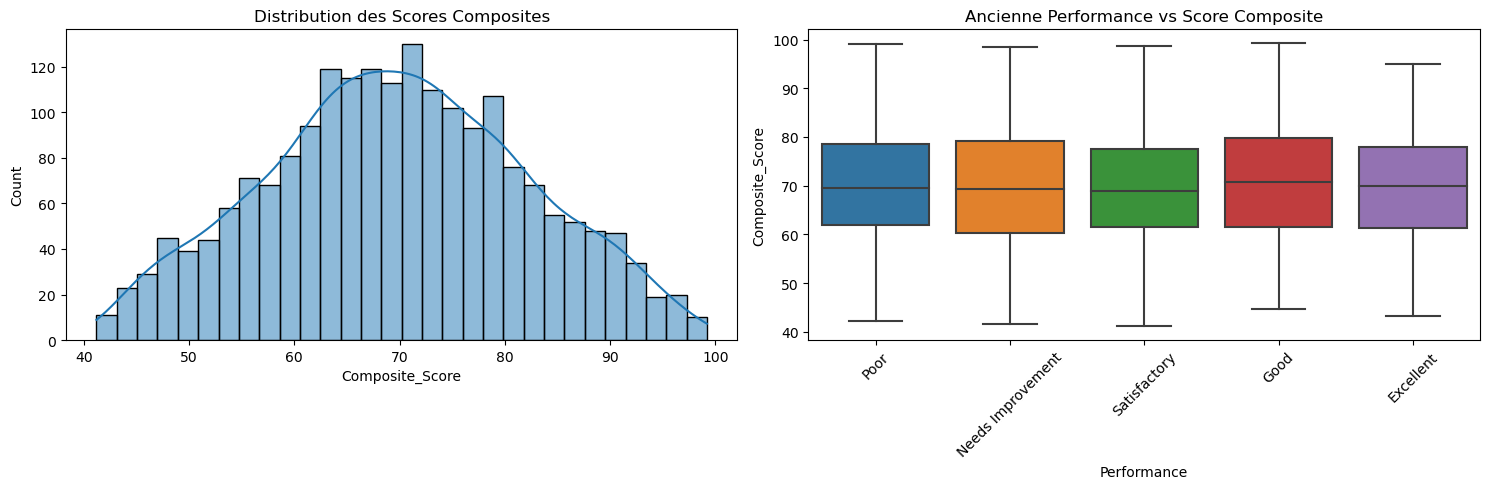

In [14]:
plt.figure(figsize=(15, 5))

# Distribution des scores composites
plt.subplot(1, 2, 1)
sns.histplot(df['Composite_Score'], bins=30, kde=True)
plt.title('Distribution des Scores Composites')

# Relation avec l'ancienne performance
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='Performance', y='Composite_Score',order=['Poor', 'Needs Improvement', 'Satisfactory', 'Good', 'Excellent'])
plt.title('Ancienne Performance vs Score Composite')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

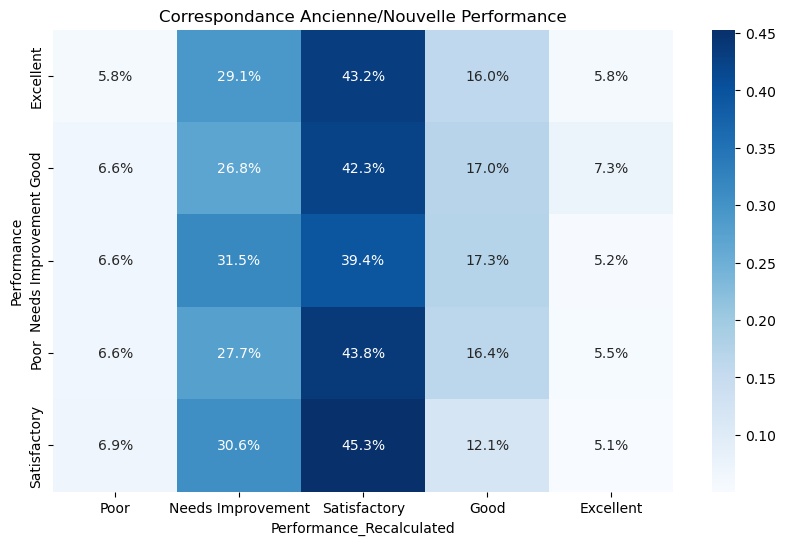

Répartition de la nouvelle performance:
Performance_Recalculated
Satisfactory         0.4275
Needs Improvement    0.2950
Good                 0.1545
Poor                 0.0660
Excellent            0.0570
Name: proportion, dtype: float64


In [15]:
# Tableau croisé ancienne vs nouvelle performance
cross_tab = pd.crosstab(df['Performance'], df['Performance_Recalculated'],
                       normalize='index')
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt='.1%', cmap='Blues')
plt.title('Correspondance Ancienne/Nouvelle Performance')
plt.show()

# Statistiques descriptives
print("Répartition de la nouvelle performance:")
print(df['Performance_Recalculated'].value_counts(normalize=True))

In [16]:
# Vérification des cas extrêmes
print("\nÉtudiants avec score composite >95:")
print(df[df['Composite_Score']>95][['GPA', 'Final Exam Scores', 'Performance', 'Performance_Recalculated']])





Étudiants avec score composite >95:
       GPA  Final Exam Scores        Performance Performance_Recalculated
57    3.91                 95               Good                Excellent
95    4.00                 93  Needs Improvement                Excellent
124   3.92                 99       Satisfactory                Excellent
137   3.83                 96               Good                Excellent
232   3.67                 99               Good                Excellent
275   3.90                 94  Needs Improvement                Excellent
498   3.96                 97               Good                Excellent
784   3.71                 99  Needs Improvement                Excellent
800   3.97                 98  Needs Improvement                Excellent
840   3.86                 96  Needs Improvement                Excellent
876   3.96                 99               Good                Excellent
919   3.93                 99               Good                Excellent
9

In [17]:
print("\nÉtudiants avec score composite <30:")
print(df[df['Composite_Score']<30][['GPA', 'Final Exam Scores', 'Performance', 'Performance_Recalculated']])


Étudiants avec score composite <30:
Empty DataFrame
Columns: [GPA, Final Exam Scores, Performance, Performance_Recalculated]
Index: []


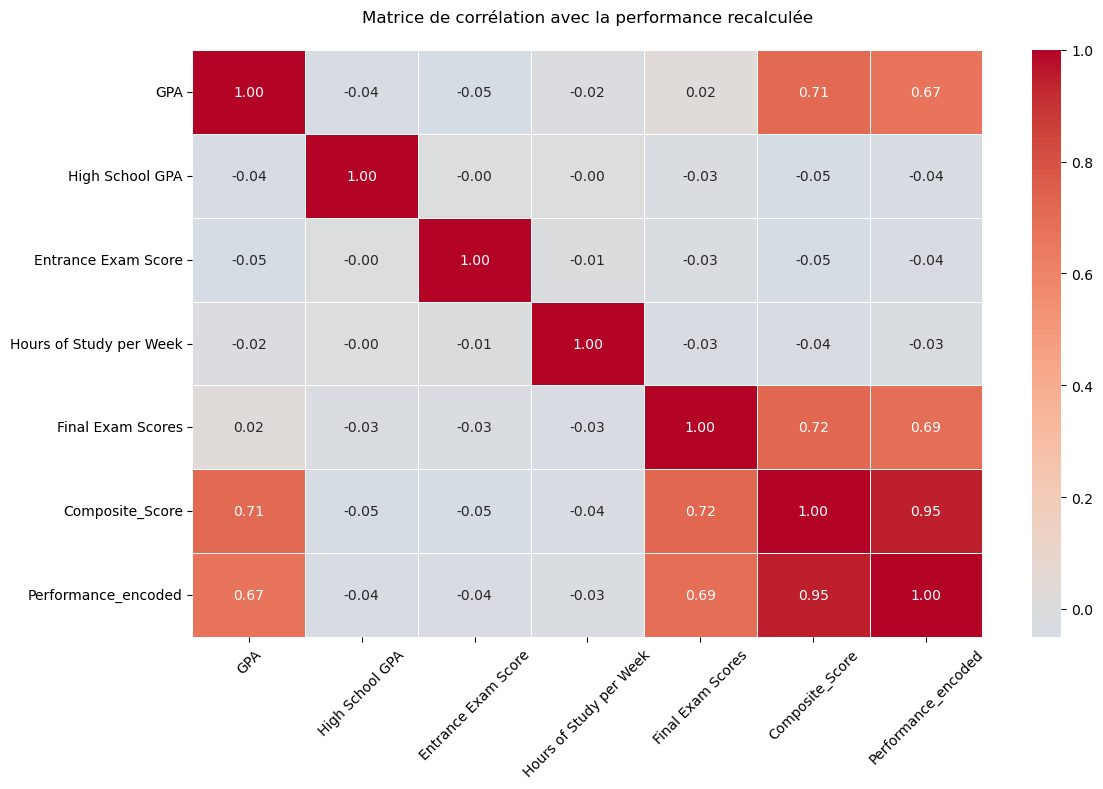

In [18]:
correct_mapping = {
    'Poor': 0,
    'Needs Improvement': 1,
    'Satisfactory': 2,
    'Good': 3,
    'Excellent': 4
}
df['Performance_encoded'] = df['Performance_Recalculated'].map(correct_mapping)
corr_vars = ['GPA', 'High School GPA', 'Entrance Exam Score', 'Hours of Study per Week', 'Final Exam Scores','Composite_Score', 'Performance_encoded']

plt.figure(figsize=(12, 8))
corr_matrix = df[corr_vars].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f",annot_kws={"size": 10}, linewidths=0.5)
plt.title("Matrice de corrélation avec la performance recalculée", pad=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

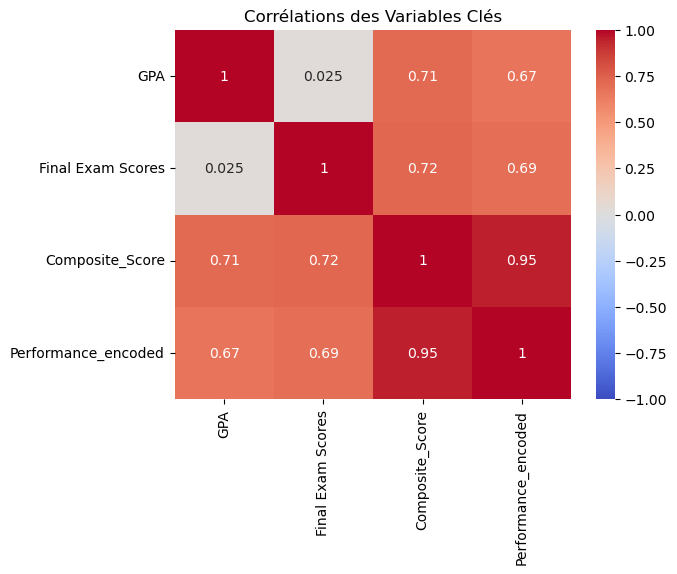

In [19]:
focus_vars = ['GPA', 'Final Exam Scores', 'Composite_Score', 'Performance_encoded']
sns.heatmap(df[focus_vars].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Corrélations des Variables Clés")
plt.show()

In [20]:
# Features et Target
X = df[['GPA', 'Final Exam Scores', 'Gender', 'Parental Education Level', 
       'Family Income', 'Hours of Study per Week']]
y = df['Performance_Recalculated']

# Encodage des variables catégorielles
X = pd.get_dummies(X, columns=['Gender', 'Parental Education Level'])

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modèle Random Forest
model = RandomForestClassifier(n_estimators=100, class_weight='balanced')
model.fit(X_train, y_train)

# Évaluation
print(classification_report(y_test, model.predict(X_test), target_names=y.unique()))

                   precision    recall  f1-score   support

     Satisfactory       0.96      0.81      0.88        27
Needs Improvement       0.92      0.86      0.89        97
             Good       0.93      0.95      0.94       171
             Poor       1.00      0.86      0.93        37
        Excellent       0.92      0.96      0.94       268

         accuracy                           0.93       600
        macro avg       0.95      0.89      0.92       600
     weighted avg       0.93      0.93      0.93       600



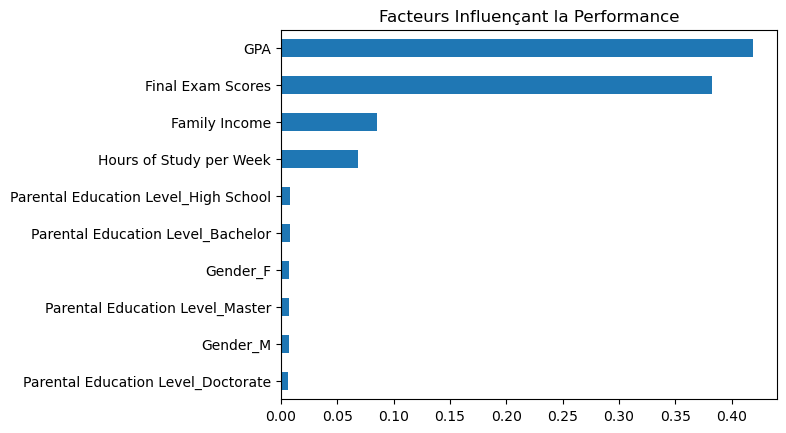

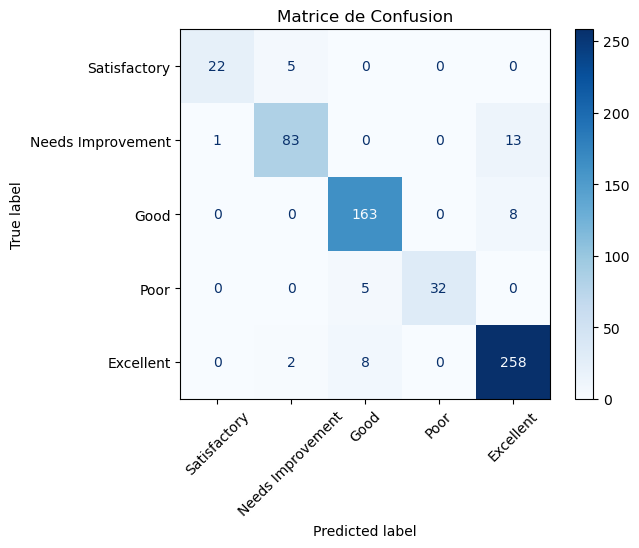

In [21]:
feature_imp = pd.Series(model.feature_importances_, index=X.columns)
feature_imp.sort_values().plot(kind='barh')
plt.title('Facteurs Influençant la Performance')
plt.show()

# Matrice de confusion
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=y.unique(), cmap='Blues',xticks_rotation=45)
plt.title('Matrice de Confusion')
plt.show()

In [22]:
# Profil "Excellent"
excellent_mask = df['Performance_Recalculated'] == 'Excellent'
print("Caractéristiques moyennes des excellents étudiants:")
print(df[excellent_mask][['GPA', 'Final Exam Scores', 'Hours of Study per Week']].mean())

# Comparaison avec les "Poor"
print("\nDifférence avec les étudiants en difficulté:")
print(df[excellent_mask].mean() - df[df['Performance_Recalculated'] == 'Poor'].mean())

Caractéristiques moyennes des excellents étudiants:
GPA                         3.706579
Final Exam Scores          93.947368
Hours of Study per Week    18.061404
dtype: float64

Différence avec les étudiants en difficulté:


TypeError: can only concatenate str (not "int") to str